# 2D "Unknown-p" ESM with KDE target
- Train target: ∇x log q_h(x) from KDE on training samples (no true p used)
- Evaluate: compare learned score vs true score (known only for evaluation)
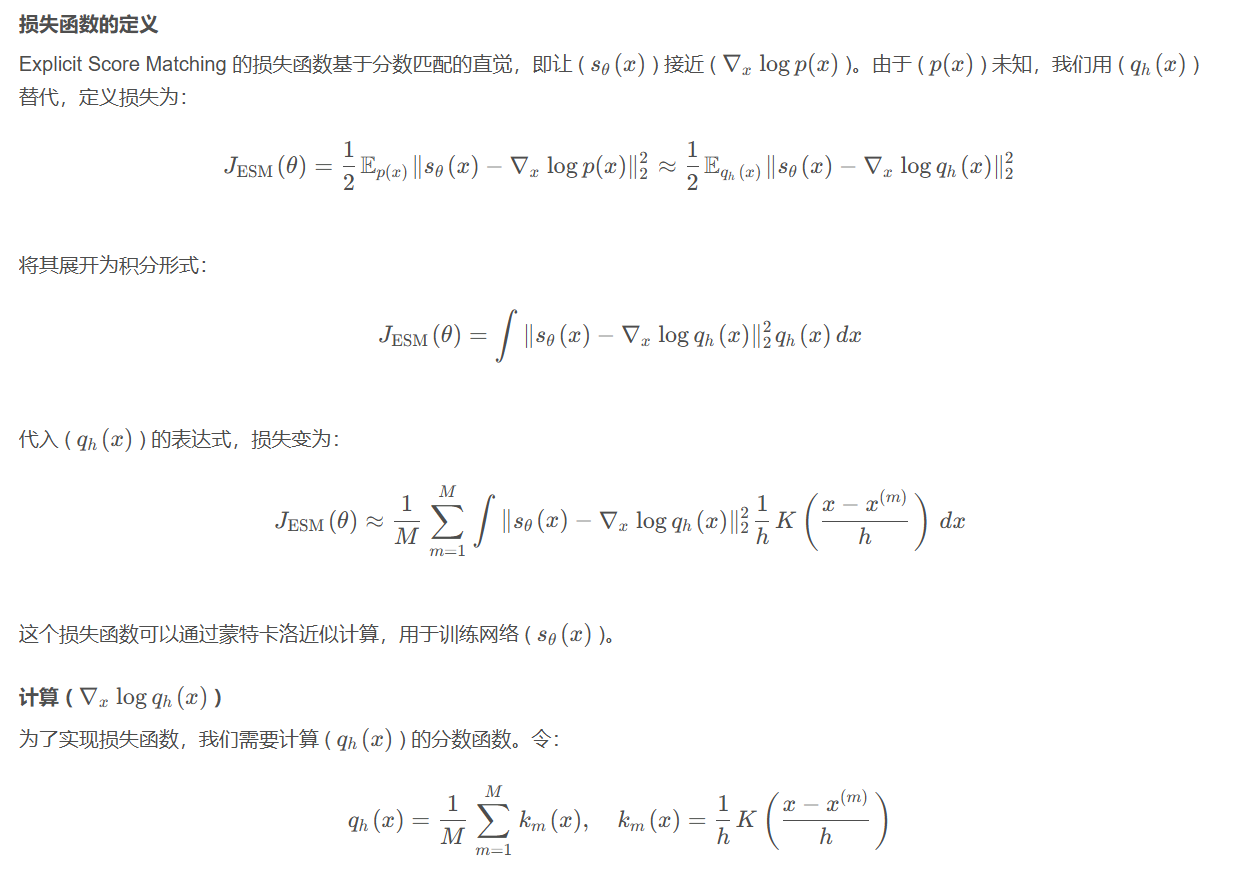
[參考網站](https://blog.csdn.net/shizheng_Li/article/details/146104162)

step   50 | train 0.0979 | val 0.0952
step  100 | train 0.0324 | val 0.0344
step  150 | train 0.0200 | val 0.0226
step  200 | train 0.0125 | val 0.0151
step  250 | train 0.0097 | val 0.0110
step  300 | train 0.0100 | val 0.0087
step  350 | train 0.0049 | val 0.0072
step  400 | train 0.0038 | val 0.0064
step  450 | train 0.0044 | val 0.0053
step  500 | train 0.0033 | val 0.0048
step  550 | train 0.0026 | val 0.0049
step  600 | train 0.0036 | val 0.0040
step  650 | train 0.0024 | val 0.0038
step  700 | train 0.0039 | val 0.0036
step  750 | train 0.0020 | val 0.0035
step  800 | train 0.0038 | val 0.0035
step  850 | train 0.0032 | val 0.0033
step  900 | train 0.0036 | val 0.0031
step  950 | train 0.0026 | val 0.0031
step 1000 | train 0.0018 | val 0.0030
step 1050 | train 0.0030 | val 0.0030
step 1100 | train 0.0022 | val 0.0030
step 1150 | train 0.0014 | val 0.0031
step 1200 | train 0.0018 | val 0.0029
step 1250 | train 0.0020 | val 0.0027
step 1300 | train 0.0021 | val 0.0024
step 1350 | 

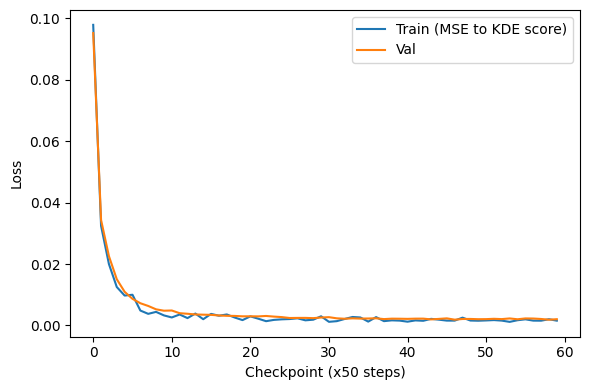

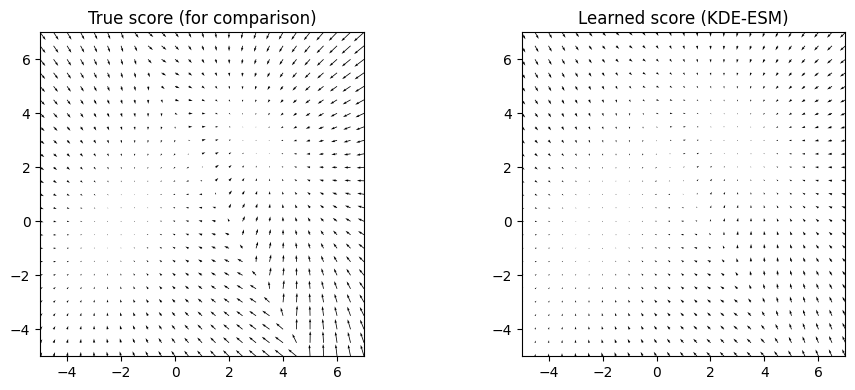

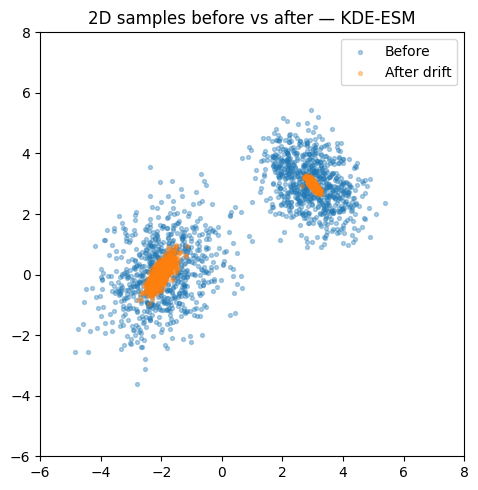

In [1]:
# ================================
# ================================
import math, torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt

torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ---------- (A)  Toy true p(x) ONLY for evaluation ----------
m1 = torch.tensor([-2.0, 0.0], device=device)
S1 = torch.tensor([[1.0, 0.3],[0.3, 1.2]], device=device)
m2 = torch.tensor([ 3.0, 3.0], device=device)
S2 = torch.tensor([[0.6,-0.2],[-0.2, 0.7]], device=device)

def sample_true(n):
    n1 = n//2; n2 = n-n1
    x1 = torch.distributions.MultivariateNormal(m1, S1).sample((n1,))
    x2 = torch.distributions.MultivariateNormal(m2, S2).sample((n2,))
    return torch.cat([x1,x2], dim=0).to(device)

def mvn_logpdf(x, mean, cov):
    L   = torch.linalg.cholesky(cov)
    y   = torch.cholesky_solve((x-mean).unsqueeze(-1), L)
    quad = ((x-mean).unsqueeze(-1) * y).sum(dim=(1,2))
    logdet = 2.0 * torch.log(torch.diag(L)).sum()
    d = x.size(-1)
    return -0.5*(d*math.log(2*math.pi) + logdet + quad)

@torch.no_grad()
def true_score(x):                  # ONLY for evaluation
    with torch.enable_grad():
        x = x.clone().detach().requires_grad_(True)
        lp = mvn_logpdf(x, m1, S1)
        lp2= mvn_logpdf(x, m2, S2)
        m  = torch.maximum(lp, lp2)
        logp = m + torch.log(0.5*torch.exp(lp-m) + 0.5*torch.exp(lp2-m))
        (g,) = torch.autograd.grad(logp.sum(), x, create_graph=False)
    return g

# ---------- (B)  KDE score target: ∇x log q_h(x) ----------
# q_h(x) = (1/M) Σ K(||x-xm||/h); K(z)=exp(-||z||^2/2)
# ∇x log q_h(x) = Σ w_m(x) * (x_m - x) / h^2, where w_m ∝ K(...)
def kde_score(x, Xref, h, eps=1e-12):
    # x: (B,2), Xref: (M,2)
    diff = x[:, None, :] - Xref[None, :, :]           # (B,M,2)
    sq   = (diff**2).sum(dim=2)                       # (B,M)
    k    = torch.exp(-0.5 * sq / (h**2))              # Gaussian kernel
    w    = k / (k.sum(dim=1, keepdim=True) + eps)     # (B,M)
    grad = (w[..., None] * (-diff)/(h**2)).sum(dim=1) # Σ w * (-(x-xm))/h^2
    return grad                                        # (B,2)

def silverman_bandwidth(X):
    # scalar h via Silverman rule-of-thumb
    n, d = X.shape
    std  = X.std(dim=0).mean()
    return 1.06 * std * (n ** (-1.0/(d+4)))

# ---------- (C)  Model ----------
class ScoreMLP2D(nn.Module):
    def __init__(self, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden), nn.SiLU(),
            nn.Linear(hidden, hidden), nn.SiLU(),
            nn.Linear(hidden, 2)
        )
    def forward(self, x): return self.net(x)

model = ScoreMLP2D().to(device)
opt   = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# ---------- (D)  Data splits ----------
train_x = sample_true(8000)  # 只把樣本當作未知分布的資料
val_x   = sample_true(2000)
test_x  = sample_true(2000)

# KDE bandwidth & reference set（可抽子集加速）
Xref = train_x               # 也可選 train_x[torch.randperm(len(train_x))[:2000]]
h = silverman_bandwidth(Xref)

# ---------- (E)  Loss: MSE to KDE score (no divergence, p is unknown) ----------
def esm_kde_loss(x):
    # x 來自資料樣本（近似 E_{q_h}）
    s_hat = model(x)                        # (B,2)
    with torch.no_grad():
        s_kde = kde_score(x, Xref, h)       # (B,2) 目標：∇ log q_h(x)
    return F.mse_loss(s_hat, s_kde)

@torch.no_grad()
def esm_kde_loss_eval(x):
    model.eval()
    s_hat = model(x)
    s_kde = kde_score(x, Xref, h)
    return F.mse_loss(s_hat, s_kde).item()

# ---------- (F)  Train ----------
BATCH, STEPS = 1024, 3000
tr_hist, va_hist = [], []

for step in range(1, STEPS+1):
    model.train()
    idx = torch.randint(0, len(train_x), (BATCH,), device=device)
    xb = train_x[idx]
    loss = esm_kde_loss(xb)
    opt.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    opt.step()

    if step % 50 == 0:
        val = esm_kde_loss_eval(val_x)
        tr_hist.append(loss.item()); va_hist.append(val)
        print(f"step {step:4d} | train {loss.item():.4f} | val {val:.4f}")

# ---------- (G)  Evaluate vs TRUE score (for comparison only) ----------
@torch.no_grad()
def score_mse_to_true(x):
    s_true = true_score(x)
    s_hat  = model(x)
    return F.mse_loss(s_hat, s_true).item()

print("\n[Eval] score-MSE to TRUE p(x)")
print("  Val:", score_mse_to_true(val_x))
print("  Test:", score_mse_to_true(test_x))

# ---------- (H)  Plots ----------
plt.figure(figsize=(6,4))
plt.plot(tr_hist, label="Train (MSE to KDE score)")
plt.plot(va_hist, label="Val")
plt.xlabel("Checkpoint (x50 steps)"); plt.ylabel("Loss")
plt.legend(); plt.tight_layout(); plt.show()

# Vector field: learned vs true
with torch.no_grad():
    xx, yy = torch.meshgrid(
        torch.linspace(-5, 7, 25, device=device),
        torch.linspace(-5, 7, 25, device=device),
        indexing="xy"
    )
    grid = torch.stack([xx.reshape(-1), yy.reshape(-1)], dim=1)
    s_learn = model(grid)
s_true_grid = true_score(grid)

def quiver(ax, pts, vec, title):
    ax.quiver(pts[:,0].cpu(), pts[:,1].cpu(),
              vec[:,0].cpu(), vec[:,1].cpu(), angles='xy', scale_units='xy', scale=25)
    ax.set_title(title); ax.set_aspect('equal'); ax.set_xlim(-5,7); ax.set_ylim(-5,7)

fig, axs = plt.subplots(1,2, figsize=(10,4))
quiver(axs[0], grid, s_true_grid, "True score (for comparison)")
quiver(axs[1], grid, s_learn,    "Learned score (KDE-ESM)")
plt.tight_layout(); plt.show()

# Drift before/after using learned score
@torch.no_grad()
def drift(model, x, eta=0.05, steps=40):
    x = x.clone()
    for _ in range(steps):
        x += eta * model(x)
    return x

x0 = sample_true(1500)
x_after = drift(model, x0, eta=0.05, steps=40)

plt.figure(figsize=(5,5))
plt.scatter(x0[:,0].cpu(),     x0[:,1].cpu(),     s=8, alpha=0.35, label='Before')
plt.scatter(x_after[:,0].cpu(),x_after[:,1].cpu(),s=8, alpha=0.35, label='After drift')
plt.legend(); plt.gca().set_aspect('equal'); plt.xlim(-6,8); plt.ylim(-6,8)
plt.title("2D samples before vs after — KDE-ESM")
plt.tight_layout(); plt.show()


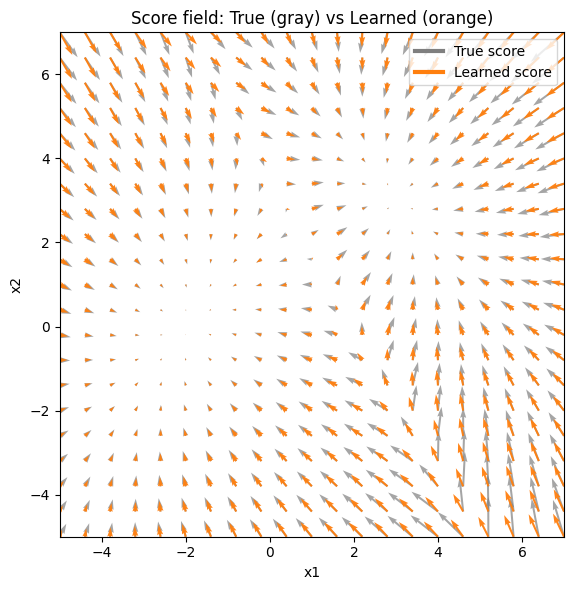

In [5]:
@torch.no_grad()
def plot_overlay_score_field(model, true_score_fn,
                             xy_range=(-5, 7, -5, 7),
                             n_grid=21,          # 稍微稀疏
                             normalize=False,    # 看方向+強度
                             scale=12,           # 調小 -> 箭頭更長
                             width=0.004,        # 箭頭線寬
                             minlength=0.05,     # 最短箭頭長度
                             device=None):
    if device is None:
        device = next(model.parameters()).device
    xmin, xmax, ymin, ymax = xy_range
    xx, yy = torch.meshgrid(
        torch.linspace(xmin, xmax, n_grid, device=device),
        torch.linspace(ymin, ymax, n_grid, device=device),
        indexing="xy"
    )
    grid = torch.stack([xx.reshape(-1), yy.reshape(-1)], dim=1)

    s_learn = model(grid)
    s_true  = true_score_fn(grid)

    if normalize:
        def norm(v, eps=1e-8):
            n = torch.linalg.norm(v, dim=1, keepdim=True).clamp_min(eps)
            return v / n
        s_learn, s_true = norm(s_learn), norm(s_true)

    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    fig, ax = plt.subplots(1, 1, figsize=(6,6))

    # 先畫 True（灰色、透明、在後面）
    ax.quiver(grid[:,0].cpu(), grid[:,1].cpu(),
              s_true[:,0].cpu(),  s_true[:,1].cpu(),
              angles='xy', scale_units='xy', scale=scale,
              color='#7f7f7f', alpha=0.7, width=width,
              minlength=minlength, zorder=1)

    # 再畫 Learned（橘色、在上面）
    ax.quiver(grid[:,0].cpu(), grid[:,1].cpu(),
              s_learn[:,0].cpu(), s_learn[:,1].cpu(),
              angles='xy', scale_units='xy', scale=scale,
              color='#ff7f0e', alpha=0.95, width=width,
              minlength=minlength, zorder=2)

    ax.set_aspect('equal'); ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
    ax.set_title("Score field: True (gray) vs Learned (orange)")
    ax.set_xlabel("x1"); ax.set_ylabel("x2")

    handles = [Line2D([0],[0], color='#7f7f7f', lw=3, label='True score'),
               Line2D([0],[0], color='#ff7f0e', lw=3, label='Learned score')]
    ax.legend(handles=handles, loc='upper right')
    plt.tight_layout(); plt.show()
    
plot_overlay_score_field(model, true_score,
                             xy_range=(-5, 7, -5, 7),
                             n_grid=21,          # 稍微稀疏
                             normalize=False,    # 看方向+強度
                             scale=12,           # 調小 -> 箭頭更長
                             width=0.004,        # 箭頭線寬
                             minlength=0.05,     # 最短箭頭長度
                             device=None)